In [108]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import copy
import missingno as msno
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import sys
import os
sys.path.insert(0, '../../')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier

from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')



RendererRegistry.enable('default')

In [131]:
full_model_data = ModelDataLoader('003')
full_model_data.df.to_csv('output2.csv', index=False) 
full_model_data.df.head(1)
data_df = full_model_data.df

In [162]:
data_df = pd.read_csv('/Users/tetyananesdill/music_modeling_capstone/notebooks/exploratory/output2.csv')

In [163]:
len(data_df)

20957

In [164]:
to_remove = ['spoken', 'easy listening' , 'international' , 'instrumental']

data_df = data_df[~data_df['label'].isin(to_remove)]
                  


In [165]:
class_dis = pd.DataFrame(data_df['label'].value_counts(normalize=True) * 100).reset_index()

alt.Chart(class_dis).mark_bar().encode(
    x=alt.X('label:Q', title=None),
    y=alt.Y('index:N', sort='-x', title=None),
    color='label:Q')

alt.Chart(...)

## Train - Test Split 

In [166]:
y = data_df['label']
x = data_df[['spectral_centroids_mean',
             'spectral_centroids_delta_mean',
             'spectral_centroids_accelerate_mean',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
            'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
y_train.count()

14888

## SMOTE for class imbalance 

In [167]:
smote = SMOTE()

print(len(X_train))
print(len(y_train))

x_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

print(len(x_smote))


14888
14888
51000


# Classificaiton 

## Original dataset with all features 

In [168]:
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train, y_train)

y_pred = RandomForest.predict(X_test)
len(X_train)

14888

In [169]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

             blues       0.68      0.45      0.54        29
         classical       0.66      0.80      0.73       117
           country       0.50      0.23      0.31        31
        electronic       0.59      0.73      0.65       974
      experimental       0.52      0.32      0.40       385
              folk       0.50      0.58      0.54       245
            hiphop       0.58      0.49      0.53       379
              jazz       0.67      0.18      0.29        87
oldtime / historic       0.93      0.94      0.93        80
               pop       0.49      0.07      0.12       238
              rock       0.68      0.82      0.74      1115
           soulrnb       0.69      0.26      0.38        42

          accuracy                           0.62      3722
         macro avg       0.62      0.49      0.51      3722
      weighted avg       0.61      0.62      0.59      3722



## Full dataset/ smote for imbalanced classes

### Random Forest

In [171]:
RandomForest = RandomForestClassifier(random_state=42)

RandomForest.fit(x_smote, y_smote)

y_pred_smote = RandomForest.predict(X_test)

In [172]:
print(classification_report(y_test, y_pred_smote))

                    precision    recall  f1-score   support

             blues       0.45      0.45      0.45        29
         classical       0.57      0.79      0.67       117
           country       0.26      0.45      0.33        31
        electronic       0.71      0.57      0.64       974
      experimental       0.39      0.43      0.41       385
              folk       0.43      0.62      0.51       245
            hiphop       0.54      0.66      0.59       379
              jazz       0.22      0.26      0.24        87
oldtime / historic       0.95      0.95      0.95        80
               pop       0.23      0.22      0.23       238
              rock       0.75      0.68      0.71      1115
           soulrnb       0.41      0.43      0.42        42

          accuracy                           0.58      3722
         macro avg       0.49      0.54      0.51      3722
      weighted avg       0.60      0.58      0.59      3722



### Decision Tree

In [125]:
clf = DecisionTreeClassifier()

clf = clf.fit(x_smote,y_smote)

y_pred_smote_dt = clf.predict(X_test)

In [126]:
print(classification_report(y_test, y_pred_smote_dt))

                    precision    recall  f1-score   support

         classical       0.51      0.62      0.56       119
           country       0.21      0.38      0.27        53
        electronic       0.55      0.40      0.46       950
      experimental       0.25      0.32      0.28       371
              folk       0.32      0.36      0.34       276
            hiphop       0.42      0.46      0.44       395
              jazz       0.11      0.27      0.16        82
oldtime / historic       0.82      0.85      0.83        74
               pop       0.13      0.21      0.16       245
              rock       0.68      0.48      0.56      1091
           soulrnb       0.12      0.37      0.18        35

          accuracy                           0.42      3691
         macro avg       0.37      0.43      0.39      3691
      weighted avg       0.49      0.42      0.44      3691



### Regression

In [127]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(x_smote,y_smote)
y_pred_smote_lm = lm.predict(X_test)

In [128]:
print(classification_report(y_test, y_pred_smote_lm))

                    precision    recall  f1-score   support

         classical       0.31      0.65      0.42       119
           country       0.10      0.42      0.16        53
        electronic       0.57      0.26      0.36       950
      experimental       0.24      0.17      0.20       371
              folk       0.34      0.57      0.43       276
            hiphop       0.33      0.55      0.41       395
              jazz       0.13      0.21      0.16        82
oldtime / historic       0.58      0.99      0.73        74
               pop       0.09      0.03      0.04       245
              rock       0.64      0.51      0.57      1091
           soulrnb       0.07      0.43      0.11        35

          accuracy                           0.39      3691
         macro avg       0.31      0.43      0.33      3691
      weighted avg       0.46      0.39      0.39      3691



<BarContainer object of 15 artists>

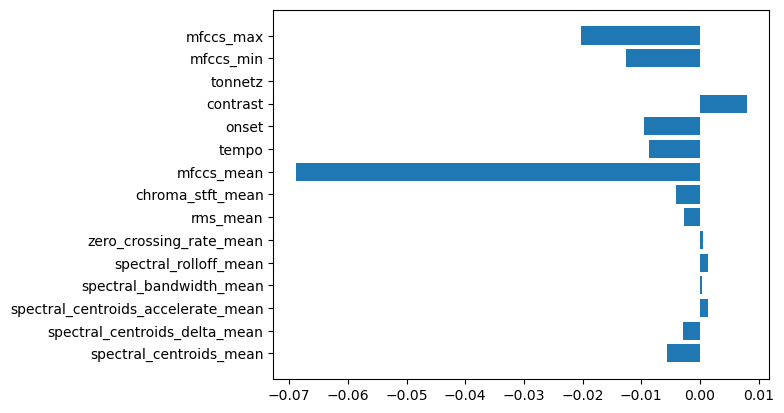

In [129]:
importance = lm.coef_[0]

plt.barh(feature_names, importance)


In [ ]:
lm.predict_proba_

### Gradient Booster

In [130]:
gb_clf = GradientBoostingClassifier()

gb_clf.fit(x_smote,y_smote)

y_pred_gb = gb_clf.predict(X_test)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test, y_pred_gb))

### SVM

In [ ]:
svm = svm.SVC() 

svm.fit(x_smote, y_smote)
y_pred_svm = svm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_svm))

### NB

In [ ]:
X_train_NB = copy.deepcopy(X_train)
X_train_NB['mfccs_min_abs'] = abs(X_train_NB['mfccs_min'])
X_train_NB['mfccs_mean_abs'] = abs(X_train_NB['mfccs_mean'])
X_train_NB['tonnetz_abs'] = abs(X_train_NB['tonnetz'])
X_train_NB['spectral_centroids_delta_mean_abs'] = abs(X_train_NB['spectral_centroids_delta_mean'])
X_train_NB['spectral_centroids_accelerate_mean_abs'] = abs(X_train_NB['spectral_centroids_accelerate_mean'])

X_train_abs = X_train_NB[['spectral_centroids_mean',
             'spectral_centroids_delta_mean_abs',
             'spectral_centroids_accelerate_mean_abs',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean_abs',
            'tempo',
            'onset',
            'contrast',
            'tonnetz_abs',
            'mfccs_min_abs',
            'mfccs_max']]

X_test_NB = copy.deepcopy(X_test)
X_test_NB['mfccs_min_abs'] = abs(X_test_NB['mfccs_min'])
X_test_NB['mfccs_mean_abs'] = abs(X_test_NB['mfccs_mean'])
X_test_NB['tonnetz_abs'] = abs(X_test_NB['tonnetz'])
X_test_NB['spectral_centroids_delta_mean_abs'] = abs(X_test_NB['spectral_centroids_delta_mean'])
X_test_NB['spectral_centroids_accelerate_mean_abs'] = abs(X_test_NB['spectral_centroids_accelerate_mean'])

X_test_abs = X_test_NB[['spectral_centroids_mean',
             'spectral_centroids_delta_mean_abs',
             'spectral_centroids_accelerate_mean_abs',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean_abs',
            'tempo',
            'onset',
            'contrast',
            'tonnetz_abs',
            'mfccs_min_abs',
            'mfccs_max']]

In [ ]:
model = MultinomialNB()
model.fit(X_train_abs, (y_train))
y_pred = model.predict(X_test_abs)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
report = classification_report(y_test, y_pred)
print(report)

## Reduced features/ smote for class imbalance 

In [ ]:
#take out two features that do not have much variation based on genre & have the lowest feature importance 
# 'spectral_centroids_delta_mean',
# 'spectral_centroids_accelerate_mean',

#take out highly correlated features:
#spectral_rolloff
#spectral bandwidth 

x_reduced_train = train_df[['spectral_centroids_mean',
           #  'spectral_centroids_delta_mean',
           #  'spectral_centroids_accelerate_mean',
            # 'spectral_bandwidth_mean',
            # 'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
           # 'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

x_reduced_test = X_test[['spectral_centroids_mean',
          #   'spectral_centroids_delta_mean',
           #  'spectral_centroids_accelerate_mean',
           #  'spectral_bandwidth_mean',
           #  'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
          #  'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

x_smote_reduced, y_smote_reduced = smote.fit_resample(x_reduced_train, y_train)


In [ ]:
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(x_smote_reduced, y_smote_reduced)

y_pred_smote_sm = RandomForest.predict(x_reduced_test)

In [ ]:
print(classification_report(y_test, y_pred_smote_sm))

## Try to tune parameters for Random Forest

In [173]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [174]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_test, y_test)

rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 50,
 'bootstrap': True}

In [ ]:
{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

In [175]:
RandomForest_2 = RandomForestClassifier(random_state=42,
                                     n_estimators=  1600,
                                     min_samples_split = 2,
                                     min_samples_leaf = 1,
                                     max_depth = 50,
                                     bootstrap = True)

RandomForest_2.fit(x_smote, y_smote)

y_pred_smote = RandomForest_2.predict(X_test)

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.3s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.9s
[CV] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   9.2s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   4.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   7.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   9.2s
[CV] END bootstrap=False, max_depth=20, min_s

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   6.1s
[CV] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  10.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time=  14.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   8.0s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  12.4s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   2.3s
[CV] END bootstrap=False, max_depth=40, min_samples

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.6s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   5.9s
[CV] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   9.0s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   4.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   7.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   9.4s
[CV] END bootstrap=False, max_depth=20, min_s

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   8.6s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   6.1s
[CV] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   9.2s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   4.1s
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=  10.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, min_sam

In [176]:
print(classification_report(y_test, y_pred_smote))

                    precision    recall  f1-score   support

             blues       0.45      0.52      0.48        29
         classical       0.59      0.80      0.68       117
           country       0.27      0.39      0.32        31
        electronic       0.72      0.57      0.64       974
      experimental       0.39      0.44      0.41       385
              folk       0.44      0.63      0.52       245
            hiphop       0.54      0.67      0.60       379
              jazz       0.24      0.28      0.26        87
oldtime / historic       0.94      0.95      0.94        80
               pop       0.26      0.22      0.24       238
              rock       0.76      0.70      0.73      1115
           soulrnb       0.41      0.45      0.43        42

          accuracy                           0.59      3722
         macro avg       0.50      0.55      0.52      3722
      weighted avg       0.61      0.59      0.60      3722



In [177]:
round(accuracy_score(y_test, y_pred_smote),2)

0.59

<BarContainer object of 15 artists>

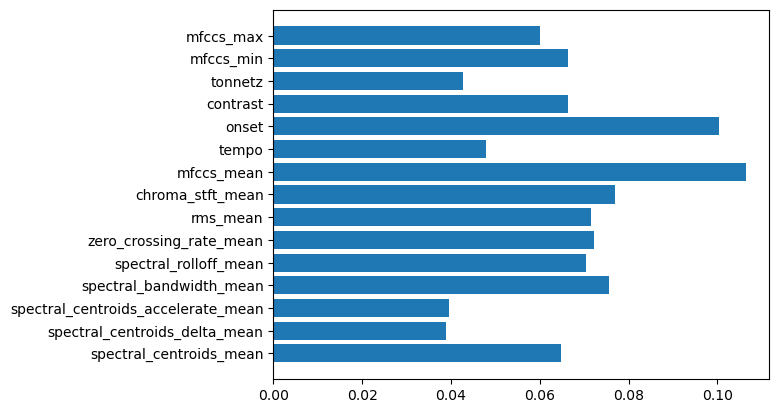

In [179]:
feature_importances = RandomForest.feature_importances_
feature_names = x_smote.columns
plt.barh(feature_names, feature_importances)


In [195]:
genres= ['rock', 'electronic', 'soulrnb', 'hiphop', 'classical', 'folk',
       'pop', 'country', 'oldtime / historic', 'experimental', 'jazz',
       'blues']

In [194]:
cm = confusion_matrix(y_test, y_pred_smote, labels=genres)

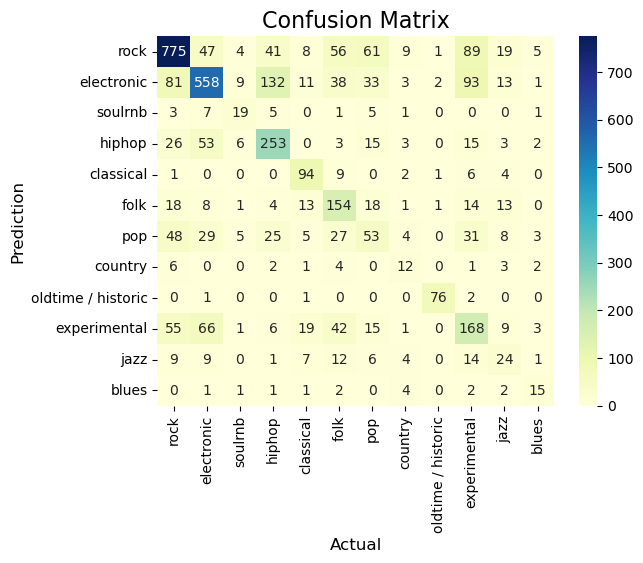

In [197]:
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=genres, yticklabels=genres)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()